<a href="https://colab.research.google.com/github/LuisaBeccar/proyecto_nlp/blob/main/classification_symptoms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

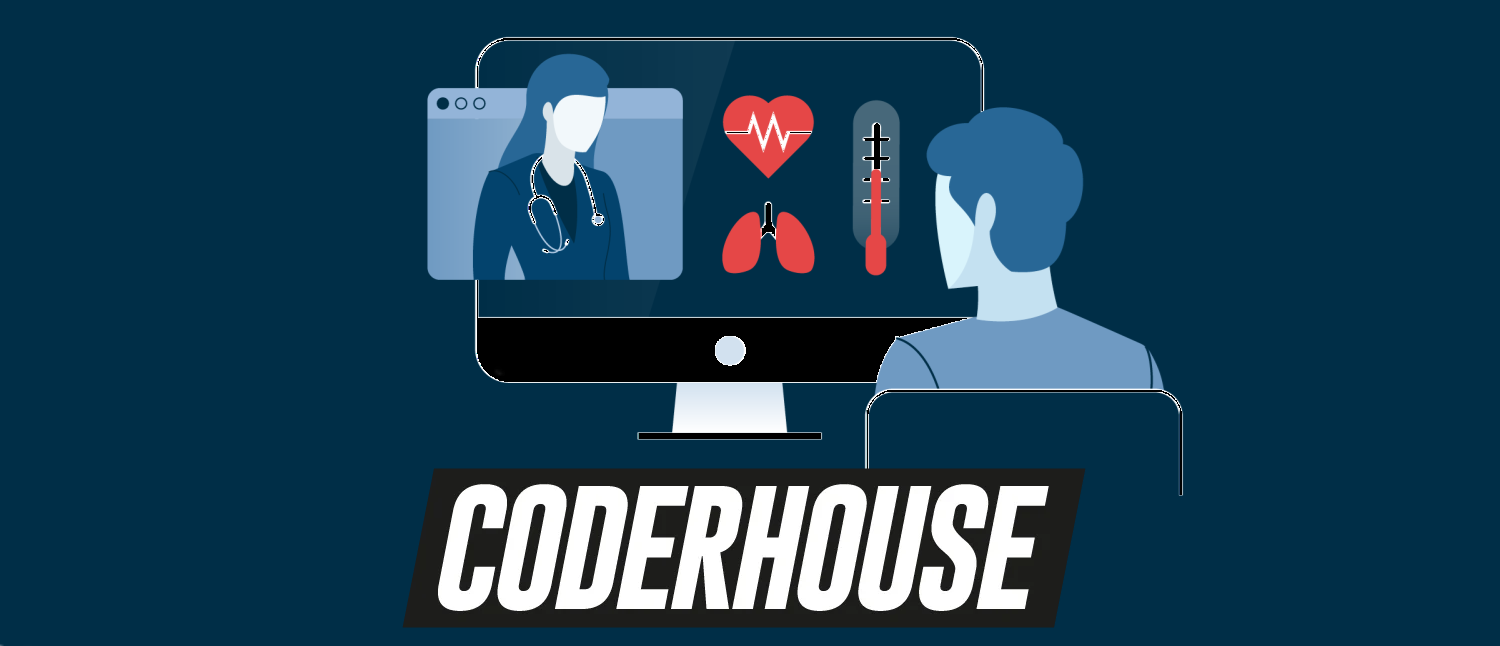

# CoderHouse: NLP & deep learning para la Ciencia de Datos
## Comision: 61195 - Nov-Dic 2024
## Luisa Beccar Varela

  ## Clasificación de enfermedades segun descripción de sintomas. <br>


**Introducción** <br>

Metas:<br>
  Combinar lo que aprendido  sobre el procesamiento de texto en lenguage natural y los modelos de clasificación de machine learning para desarrollar algoritmos capaces de clasificar los sintomas descripctos en especialidades, que podria aplicarse a nuevos sintomas introducidos por new inputs. Usare herramientas de vectorizacion con distintos parametros (Count Vectorizer con stop words, lematizer y ngramas), modelos de machine learning para problemas de clasificacion: Logistic Regression, Random  Forest, Support Vector Machine y Gradient Boosting; cross validation con Stratified K fold, y busqueda de hiperparámetros con Halving Random Search.
  Para el mejor algoritmo de Logistic Regression buscare los coeficientes de los ngramas de cada categoria.<br>
  <br>

**Contexto empresarial**<br>
 Un científico de datos en una gran empresa de telemedicina, que tiene miles de llamadas de pacientes que describen sus sintomas cada día.

La empresa quiere identificar de manera automatica la especialidad a la cual deberia deribar a cada pacinete que consulta de manera automatica segun la enfermedad que esté describiendo.

Para resolver el problema, tomaré un conjunto de datos con diagnosticos ya decifrados y entrenaré un modelo de machine learning que genere luego las pedicciones.
Disclaimer: no se sabe quien realizo la clasificacion de enfermedades por lo que la validez de las predicciones quedará entre otras cosas sujeta a si eso fue realizado correctamente.
<br>

Paso a paso:
<br>
- Dataset: de [kaggle](https://www.kaggle.com/datasets/krish0202/symptom-based-disease-labeling-datasetcsv) que descargue en mi [github](https://github.com/LuisaBeccar/proyecto_nlp/blob/main/Symptom2DiseaseKaggle.csv) de 1200 registros: descripcion y clasificacion.
Disclaimer: es una base bastante pequeña y esto afectara la capacidad de prediccion de nuevos registros

- Clasificar las 24 enfermedades en 5 subcategorias.

- Dividir el dataset en set de testeo y entrenamiento.

- Instanciar los modelos, sus hiperparamentros, el Stratified K Fold, y los vectorizadores.
    - Quise hacer que se prueben los 5 clasificadores con los 4 modelos con sus busquedas de hiperparamtros y SKF, pero luego de horas no concluia, por lo que dividi el problema en dos pasos para probar varias opciones aunque no todas.
    - Primero corri el Logistic Regression para cada uno de los 5 vectorizadores. Luego corri el vectorizador que salio con mejor accuracy en los 3 modelos restantes.

- Para la mejor combinacion modelo-vectorizador, que fue un Logistic Regression, calculé los coeficientes de los bigramas de cada categoria de enfermedades.

- Para terminar, propongo un espacio de prueba con nuevos inputs y para que el lector pruebe escribiendo una descripcion en ingles y el mejor modelo prediga.


In [14]:
%%capture
# librerias

import pandas as pd
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, KFold, GridSearchCV, HalvingGridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer, WordNetLemmatizer, LancasterStemmer
from nltk import word_tokenize
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/LuisaBeccar/proyecto_nlp/refs/heads/main/Symptom2DiseaseKaggle.csv")
df.drop(columns="Unnamed: 0", inplace=True)
df.rename(columns={"text":"symptoms", "label":"illness"}, inplace=True)
df

,illness,symptoms
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...
3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,Psoriasis,"My nails have small dents or pits in them, and..."
...,...,...
1195,diabetes,I'm shaking and trembling all over. I've lost ...
1196,diabetes,"Particularly in the crevices of my skin, I hav..."
1197,diabetes,I regularly experience these intense urges and...
1198,diabetes,"I have trouble breathing, especially outside. ..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   illness   1200 non-null   object
 1   symptoms  1200 non-null   object
dtypes: object(2)
memory usage: 18.9+ KB


In [4]:
df.symptoms.value_counts()
# veo que hay descripciones repetidas

,count
symptoms,
"I've been feeling extremely scratchy, sick, and worn out. In addition, I've lost weight and have a temperature. My urine is dark, and my skin has turned yellow. Additionally, I have been experiencing stomach pain.",4
I've been feeling really weak in my muscles and my neck has been really stiff. My joints have been swelling up and it's hard for me to move around without feeling stiff. Walking has been really painful too.,3
"I've been constipated and it's really hard to go to the bathroom. When I do go, it hurts and my stool has been bloody. I've also been having some pain in my butt and my anus has been really itchy and irritated.",3
"I've been experiencing stiffness and weakness in my neck muscles recently. Since my joints have grown, it's hard for me to walk without getting stiff. Additionally, walking has been extremely uncomfortable.",2
"Since I've been constipated, using the restroom has been quite challenging. When I do go, it aches and I've had blood in my stool. My anus has been quite itchy and irritating, and I've also been experiencing some discomfort in my butt.",2
...,...
"I've been experiencing severe weariness and a sickly sensation. My throat has been really painful and I've had a fairly severe cough. My nose has been quite stuffy, and I've had significant sinus pressure. I'm really miserable and extremely exhausted.",1
I've been feeling really sick and I've had a lot of fatigue. I've had a really bad cough and my throat has been really sore. I've had a lot of sinus pressure and my nose has been really congested. I just feel really run down and miserable.,1
"I've been quite exhausted and ill. My throat has been quite painful, and I've had a fairly nasty cough. I've got a lot of chills and a pretty high temperature. Simply put, I feel really run down and feeble.",1


In [5]:
# elimino los duplicados
df.drop_duplicates(inplace=True)
df.symptoms.value_counts()

,count
symptoms,
"I have been experiencing a skin rash on my arms, legs, and torso for the past few weeks. It is red, itchy, and covered in dry, scaly patches.",1
I've recently been dealing with an itching rash on my skin. It's covered in pus-filled pimples and blackheads. My skin has also been quite sensitive.,1
"I have been experiencing intense itching, vomiting, and fatigue. I have also lost weight and have a high fever. My skin has turned yellow and my urine is dark. I have also been experiencing abdominal pain.",1
"Back pain, a productive cough, and muscle weakness have been bothering me. I have issues with dizziness and uneven balance, and my neck hurts.",1
"I have been struggling with back pain, a productive cough, and weakness in my muscles. My neck is sore and I have had problems with dizziness and unsteady balance.",1
...,...
"I can't stop coughing and I'm freezing. My sinuses are completely blocked, and I'm inundated with mucous. My chest hurts, and I'm unable to smell anything. My muscles are also really achy.",1
"I'm coughing nonstop and am really chilly. My mucus production is excessive, and my sinuses are fully clogged. I can't smell anything, and my chest hurts. My muscles are quite painful as well.",1
I can't stop coughing and I feel really cold. My sinuses are all blocked and I have a lot of mucus. My chest hurts and I can't smell anything. My muscles are also really sore.,1


In [11]:
# cuento cuantas descripciones de cada illness hay
df.illness = df.illness.str.lower()
df.illness.value_counts()


,count
illness,
psoriasis,50
varicose veins,50
peptic ulcer disease,50
drug reaction,50
allergy,50
urinary tract infection,50
hypertension,50
diabetes,50
fungal infection,50


In [12]:
enfermedades = df.illness.value_counts().reindex(df.illness.value_counts().index)
enfermedades

,count
illness,
psoriasis,50
varicose veins,50
peptic ulcer disease,50
drug reaction,50
allergy,50
urinary tract infection,50
hypertension,50
diabetes,50
fungal infection,50


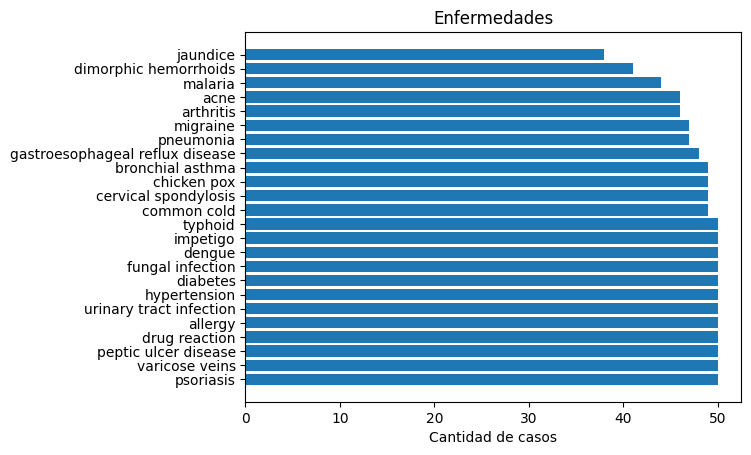

In [15]:
fig = plt.barh(enfermedades.index, enfermedades.values)
plt.title("Enfermedades")
plt.xlabel("Cantidad de casos")
plt.show()

In [16]:
# como me parecen muchas categorias y quiero simplificar mi problema voy a subclasificar estas enfermedades yo misma
enfermedades.to_csv("enfermedades.csv")

In [17]:
#luego de hacer la clasificacion, subo el archivo csv creado
enf_clas = pd.read_csv("https://raw.githubusercontent.com/LuisaBeccar/proyecto_nlp/refs/heads/main/enfermedades_clasificadas.csv")
enf_clas.illness = enf_clas.illness.str.lower()
enf_clas.clasificacion = enf_clas.clasificacion.str.lower()
enf_clas

,illness,clasificacion
0,psoriasis,dermatology
1,varicose veins,dermatology
2,peptic ulcer disease,gastroenterology
3,drug reaction,dermatology
4,allergy,dermatology
5,urinary tract infection,infectology
6,hypertension,cronic disease
7,diabetes,cronic disease
8,fungal infection,infectology
9,dengue,infectology


In [18]:
# mergeo el dataset de las descripciones e illness con el dataset de subclasificaciones para que me ponga una nueva columna con mi subclasificacion segun la ilness
df = pd.merge(df, enf_clas, on="illness", how="left")
# elimino la columna de illness que no voy a usar
df.drop(columns="illness", inplace=True)
df

,symptoms,clasificacion
0,I have been experiencing a skin rash on my arm...,dermatology
1,"My skin has been peeling, especially on my kne...",dermatology
2,I have been experiencing joint pain in my fing...,dermatology
3,"There is a silver like dusting on my skin, esp...",dermatology
4,"My nails have small dents or pits in them, and...",dermatology
...,...,...
1148,I'm shaking and trembling all over. I've lost ...,cronic disease
1149,"Particularly in the crevices of my skin, I hav...",cronic disease
1150,I regularly experience these intense urges and...,cronic disease
1151,"I have trouble breathing, especially outside. ...",cronic disease


In [19]:
# quiero mirar como quedaron distribuidas mis categorias
clasificadas = df.clasificacion.value_counts().reindex(df.clasificacion.value_counts().index)
clasificadas

,count
clasificacion,
infectology,389
dermatology,296
cronic disease,242
gastroenterology,177
traumatology,49


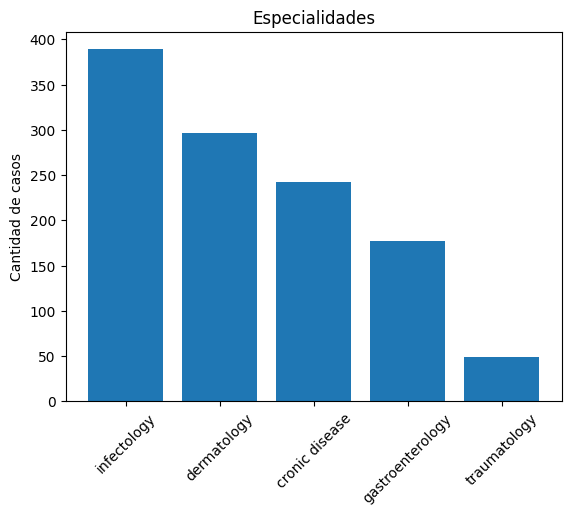

In [20]:
import matplotlib.pyplot as plt

fig = plt.bar(clasificadas.index, clasificadas.values)
plt.xticks(rotation=45)
plt.title("Especialidades")
plt.ylabel("Cantidad de casos")
plt.show()

un poco desbalanceadas... las descripciones traumatologicas son poquitas

### Preprocesamineto

In [21]:
# separo las descripciones y las etiquetas
X = df.symptoms
y = df.clasificacion

In [22]:
# Train-Test sets. no tocar el test hasta el final.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# con stratify espero me tome los conjuntos de datos para corregir el disbalance de clases

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((922,), (231,), (922,), (231,))

Para probar distintas practicas de procesamiento de texto: stop-words, bigramas, trigramas, stematizer, creo 5 vectorizadores distintos.

In [24]:
# Fitear y transsformar el train dataset en 5 tipos de vectorizadores

# 1 -Bigramas
count_vectorizer1 = CountVectorizer(ngram_range=(2,2))
X_train_v1 = count_vectorizer1.fit_transform(X_train)
X_test_v1 = count_vectorizer1.transform(X_test)

# 2 -Trigramas
count_vectorizer2 = CountVectorizer(ngram_range=(3,3))
X_train_v2 = count_vectorizer2.fit_transform(X_train)
X_test_v2 = count_vectorizer2.transform(X_test)

# 3 -Bigramas sin stopwords
count_vectorizer3 = CountVectorizer(ngram_range=(2,2), stop_words="english")
X_train_v3 = count_vectorizer3.fit_transform(X_train)
X_test_v3 = count_vectorizer3.transform(X_test)

# 4 -Trigramas sin stopqords
count_vectorizer4 = CountVectorizer(ngram_range=(3,3), stop_words="english")
X_train_v4 = count_vectorizer4.fit_transform(X_train)
X_test_v4 = count_vectorizer4.transform(X_test)

# 5 -Bigramas sin stopwords lematizado
lemmatizer = WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()
def lematizer_words(doc):
   # return (lemmatizer.lemmatize(w) for w in analyzer(doc))
    return " ".join(lemmatizer.lemmatize(w) for w in analyzer(doc))# Join the lemmatized words back into a string

count_vectorizer5 = CountVectorizer(ngram_range=(2,2), stop_words="english", preprocessor=lematizer_words ) #
X_train_v5 = count_vectorizer5.fit_transform(X_train)
X_test_v5 = count_vectorizer5.transform(X_test)


# ------

vectorizadores = {"CV1": (count_vectorizer1, X_train_v1, X_test_v1),
                  "CV2": (count_vectorizer2, X_train_v2, X_test_v2),
                  "CV3": (count_vectorizer3, X_train_v3, X_test_v3),
                  "CV4": (count_vectorizer4, X_train_v4, X_test_v4),
                  "CV5": (count_vectorizer5, X_train_v5, X_test_v5)}


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'wa'] not in stop_words.
  warnings.warn(


In [25]:
# importo modelos
from sklearn.linear_model import LogisticRegression
# solo usare el LR
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC


# importo halving gridsearchsv para hiperparametros
from sklearn.experimental import enable_halving_search_cv; # noqa
from sklearn.model_selection import HalvingGridSearchCV;

# instancio el Stratified K fold que usare para cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


**Disclaimer:** luego de intentar hacer todos los modelos con los 5 vectorizadores y que estuviera horas sin concluir, elijo quedarme con el logistic regression y solo con este probar los 5 vectorizadores.<br>
 Por lo tanto hare dos pasos, que iualmente no evaluan todas las posibilidades: <br>
primero correre los 5 vectorizadores con logistic regression, <br>
y luego el mejor vectorizador con los 4 modelos (seria esta vez sin el logistic regression ya que ya se hizo en el paso previo)

In [26]:
# instancio modelos

LR_model = LogisticRegression()
RF_model = RandomForestClassifier()
GB_model = GradientBoostingClassifier()
SVC_model = SVC()


In [27]:
# grillas de hiperparametros para cada modelo

# param grid log_reg
params_log_reg = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 500],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'l1_ratio': [0.1, 0.5, 0.9]  # Add l1_ratio for elasticnet
}

# params grid rf
params_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# params grid svm
params_svm = {
    'C':[1,10], # (el codigo que habia encontrado usaba tambien 100, 1000, pero me tardaria mucho entonces los saque)
    'gamma':[1,0.1,0.001,0.0001],
    'kernel':['linear','rbf']
    }


# params grid gb
param_gb = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'subsample': [0.7, 0.8, 1.0]
     }


### A mano cada vectorizador como seria:


In [29]:
from sklearn.model_selection import HalvingRandomSearchCV

In [ ]:
#log_reg V1
%%capture
search_log_reg1 = HalvingRandomSearchCV(LR_model, params_log_reg, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_log_reg1.fit(X_train_v1, y_train) # aplico el metodo a mis datos

best_model_log_reg1 = search_log_reg1.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_log_reg1 = best_model_log_reg1.predict(X_test_v1) # para luego obtener las metricas de clasificacion:
accuracy_log_reg1 = accuracy_score(y_test, y_pred_log_reg1)


In [ ]:
#log_reg V1
print(f"Classification Report for Logistic Regression 1:\n", classification_report(y_test, y_pred_log_reg1))
print(f"Best Model Logistic Regression 1:", best_model_log_reg1)
search_log_reg1.best_params_ # para chequear que sean como los que indica el best_model

Classification Report for Logistic Regression 1:
                   precision    recall  f1-score   support

  cronic disease       0.92      0.94      0.93        49
     dermatology       0.93      0.86      0.89        59
gastroenterology       0.95      1.00      0.97        35
     infectology       0.94      0.96      0.95        78
    traumatology       1.00      0.90      0.95        10

        accuracy                           0.94       231
       macro avg       0.95      0.93      0.94       231
    weighted avg       0.94      0.94      0.93       231

Best Model Logistic Regression 1: LogisticRegression(C=0.01, l1_ratio=0.1, max_iter=200, penalty=None,
                   solver='saga')


{'solver': 'saga',
 'penalty': None,
 'max_iter': 200,
 'l1_ratio': 0.1,
 'C': 0.01}

In [ ]:
#log_reg V2
%%capture
search_log_reg2 = HalvingRandomSearchCV(LR_model, params_log_reg, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_log_reg2.fit(X_train_v2, y_train) # aplico el metodo a mis datos

best_model_log_reg2 = search_log_reg2.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_log_reg2 = best_model_log_reg2.predict(X_test_v2) # para luego obtener las metricas de clasificacion:
accuracy_log_reg2 = accuracy_score(y_test, y_pred_log_reg2)


In [ ]:
#log_reg V2
print(f"Classification Report for Logistic Regression 2 :\n", classification_report(y_test, y_pred_log_reg2))
print(f"Best Model Logistic Regression 2:", best_model_log_reg2)
search_log_reg2.best_params_ # para chequear que sean como los que indica el best_model

Classification Report for Logistic Regression 2 :
                   precision    recall  f1-score   support

  cronic disease       0.94      0.92      0.93        49
     dermatology       0.92      0.83      0.88        59
gastroenterology       0.87      0.94      0.90        35
     infectology       0.90      0.96      0.93        78
    traumatology       1.00      0.90      0.95        10

        accuracy                           0.91       231
       macro avg       0.93      0.91      0.92       231
    weighted avg       0.91      0.91      0.91       231

Best Model Logistic Regression 2: LogisticRegression(C=0.1, l1_ratio=0.5, max_iter=500, penalty=None,
                   solver='saga')


{'solver': 'saga', 'penalty': None, 'max_iter': 500, 'l1_ratio': 0.5, 'C': 0.1}

In [30]:
#log_reg V3
%%capture
search_log_reg3 = HalvingRandomSearchCV(LR_model, params_log_reg, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_log_reg3.fit(X_train_v3, y_train) # aplico el metodo a mis datos

best_model_log_reg3 = search_log_reg3.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_log_reg3 = best_model_log_reg3.predict(X_test_v3) # para luego obtener las metricas de clasificacion:
accuracy_log_reg3 = accuracy_score(y_test, y_pred_log_reg3)


In [31]:
#log_reg V3
print(f"Classification Report for Logistic Regression 3:\n", classification_report(y_test, y_pred_log_reg3))
print(f"Best Model Logistic Regression 3:", best_model_log_reg3)
search_log_reg3.best_params_ # para chequear que sean como los que indica el best_model

Classification Report for Logistic Regression 3:
                   precision    recall  f1-score   support

  cronic disease       0.87      0.96      0.91        49
     dermatology       0.96      0.92      0.94        59
gastroenterology       0.94      0.97      0.96        35
     infectology       0.95      0.92      0.94        78
    traumatology       1.00      0.90      0.95        10

        accuracy                           0.94       231
       macro avg       0.95      0.93      0.94       231
    weighted avg       0.94      0.94      0.94       231

Best Model Logistic Regression 3: LogisticRegression(C=100, l1_ratio=0.9, solver='saga')


{'solver': 'saga', 'penalty': 'l2', 'max_iter': 100, 'l1_ratio': 0.9, 'C': 100}

In [ ]:
#log_reg V4
%%capture
search_log_reg4 = HalvingRandomSearchCV(LR_model, params_log_reg, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_log_reg4.fit(X_train_v4, y_train) # aplico el metodo a mis datos

best_model_log_reg4 = search_log_reg4.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_log_reg4 = best_model_log_reg4.predict(X_test_v4) # para luego obtener las metricas de clasificacion:
accuracy_log_reg4  = accuracy_score(y_test, y_pred_log_reg4)


In [ ]:
#log_reg V4
print(f"Classification Report for Logistic Regression 4 :\n", classification_report(y_test, y_pred_log_reg4))
print(f"Best Model Logistic Regression 4:", best_model_log_reg4)
search_log_reg4.best_params_ # para chequear que sean como los que indica el best_model

Classification Report for Logistic Regression 4 :
                   precision    recall  f1-score   support

  cronic disease       0.94      0.63      0.76        49
     dermatology       0.92      0.75      0.82        59
gastroenterology       1.00      0.71      0.83        35
     infectology       0.65      0.96      0.77        78
    traumatology       1.00      0.90      0.95        10

        accuracy                           0.80       231
       macro avg       0.90      0.79      0.83       231
    weighted avg       0.85      0.80      0.80       231

Best Model Logistic Regression 4: LogisticRegression(C=100, l1_ratio=0.9, max_iter=500, solver='liblinear')


{'solver': 'liblinear',
 'penalty': 'l2',
 'max_iter': 500,
 'l1_ratio': 0.9,
 'C': 100}

In [ ]:
#log_reg V5
%%capture
search_log_reg5 = HalvingRandomSearchCV(LR_model, params_log_reg, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_log_reg5.fit(X_train_v5, y_train) # aplico el metodo a mis datos

best_model_log_reg5 = search_log_reg5.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_log_reg5 = best_model_log_reg5.predict(X_test_v5) # para luego obtener las metricas de clasificacion:
accuracy_log_reg5 = accuracy_score(y_test, y_pred_log_reg5)


In [ ]:
#log_reg V5
print(f"Classification Report for Logistic Regression 5 :\n", classification_report(y_test, y_pred_log_reg5))
print(f"Best Model Logistic Regression 5:", best_model_log_reg5)
search_log_reg5.best_params_ # para chequear que sean como los que indica el best_model

Classification Report for Logistic Regression 5 :
                   precision    recall  f1-score   support

  cronic disease       0.88      0.94      0.91        49
     dermatology       0.94      0.86      0.90        59
gastroenterology       0.97      0.97      0.97        35
     infectology       0.91      0.95      0.93        78
    traumatology       1.00      0.90      0.95        10

        accuracy                           0.93       231
       macro avg       0.94      0.92      0.93       231
    weighted avg       0.93      0.93      0.93       231

Best Model Logistic Regression 5: LogisticRegression(C=100, l1_ratio=0.9, solver='saga')


{'solver': 'saga', 'penalty': 'l2', 'max_iter': 100, 'l1_ratio': 0.9, 'C': 100}

In [ ]:

vectorizadores = ["V1", "V2", "V3", "V4", "V5"]
accuracy_vect = [accuracy_log_reg1,accuracy_log_reg2,accuracy_log_reg3,accuracy_log_reg4,accuracy_log_reg5]

resultados_log_reg_vectorizadores = pd.DataFrame({'Vectorizador': vectorizadores, 'Accuracy': accuracy_vect})
resultados_log_reg_vectorizadores.round(3)

,Vectorizador,Accuracy
0,V1,0.935
1,V2,0.913
2,V3,0.939
3,V4,0.797
4,V5,0.926


El mejor fue el tercero: bigramas sin stopwords

### Probando el tercer vectorizador en los 4 modelos de manera manual seria asi:(silencio el logistic regression que ya se hizo)  

In [ ]:
#log_reg3
%%capture
"""
search_log_reg = HalvingRandomSearchCV(LR_model, params_log_reg, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_log_reg.fit(X_train_v3, y_train) # aplico el metodo a mis datos

best_model_log_reg = search_log_reg.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_log_reg = best_model_log_reg.predict(X_test_v3) # para luego obtener las metricas de clasificacion:
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
"""

In [ ]:
#log_reg3
"""
print(f"Classification Report for Logistic Regression :\n", classification_report(y_test, y_pred_log_reg))
print(f"Best Model Logistic Regression:", best_model_log_reg)
search_log_reg.best_params_ # para chequear que sean como los que indica el best_model
"""

Classification Report for Logistic Regression :
                   precision    recall  f1-score   support

  Cronic Disease       0.92      0.94      0.93        49
     Dermatology       0.93      0.88      0.90        59
Gastroenterology       0.95      1.00      0.97        35
     Infectology       0.94      0.95      0.94        78
    Traumatology       1.00      0.90      0.95        10

        accuracy                           0.94       231
       macro avg       0.95      0.93      0.94       231
    weighted avg       0.94      0.94      0.93       231

Best Model Logistic Regression: LogisticRegression(C=0.1, l1_ratio=0.5, max_iter=500, penalty=None,
                   solver='saga')


{'solver': 'saga', 'penalty': None, 'max_iter': 500, 'l1_ratio': 0.5, 'C': 0.1}

In [ ]:
# random forest 3
%%capture
search_rf = HalvingRandomSearchCV(RF_model, params_rf, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_rf.fit(X_train_v3, y_train) # aplico el metodo a mis datos

best_model_rf = search_rf.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_rf = best_model_rf.predict(X_test_v3) # para luego obtener las metricas de clasificacion
accuracy_rf = accuracy_score(y_test, y_pred_rf)

In [ ]:
# random forest 3
print(f"Classification Report for Random Forest :\n", classification_report(y_test, y_pred_rf))
print(f"Best Model Random Forest:", best_model_rf)
search_rf.best_params_ # para chequear que sean como los que indica el best_model

Classification Report for Random Forest :
                   precision    recall  f1-score   support

  cronic disease       0.87      0.69      0.77        49
     dermatology       0.91      0.86      0.89        59
gastroenterology       1.00      0.80      0.89        35
     infectology       0.76      0.95      0.84        78
    traumatology       0.90      0.90      0.90        10

        accuracy                           0.85       231
       macro avg       0.89      0.84      0.86       231
    weighted avg       0.86      0.85      0.85       231

Best Model Random Forest: RandomForestClassifier(max_features='log2', n_estimators=50)


{'n_estimators': 50,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None}

In [ ]:
# svm 3
%%capture
search_svc = HalvingRandomSearchCV(SVC_model, params_svm, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_svc.fit(X_train_v3, y_train) # aplico el metodo a mis datos

best_model_svc = search_svc.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_svc = best_model_svc.predict(X_test_v3) # para luego obtener las metricas de clasificacion
accuracy_svc = accuracy_score(y_test, y_pred_svc)

In [ ]:
# svm 3
print(f"Classification Report for Support Vector Machine Classifier :\n", classification_report(y_test, y_pred_svc))
print(f"Best Model Support Vector Machine Classifier:", best_model_svc)
search_svc.best_params_ # para chequear que sean como los que indica el best_model

Classification Report for Support Vector Machine Classifier :
                   precision    recall  f1-score   support

  cronic disease       0.91      0.82      0.86        49
     dermatology       0.84      0.97      0.90        59
gastroenterology       1.00      0.89      0.94        35
     infectology       0.95      0.96      0.96        78
    traumatology       1.00      0.90      0.95        10

        accuracy                           0.92       231
       macro avg       0.94      0.91      0.92       231
    weighted avg       0.92      0.92      0.92       231

Best Model Support Vector Machine Classifier: SVC(C=10, gamma=0.0001, kernel='linear')


{'kernel': 'linear', 'gamma': 0.0001, 'C': 10}

In [ ]:
# gb 3
%%capture
search_gb = HalvingRandomSearchCV(GB_model, param_gb, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_gb.fit(X_train_v3, y_train) # aplico el metodo a mis datos

best_model_gb = search_gb.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_gb = best_model_gb.predict(X_test_v3) # para luego obtener las metricas de clasificacion
accuracy_gb = accuracy_score(y_test, y_pred_gb)

In [ ]:
# gb 3
print(f"Classification Report for Gradient Boosting :\n", classification_report(y_test, y_pred_gb))
print(f"Best Model Gradient Boosting:", best_model_gb)
search_gb.best_params_ # para chequear que sean como los que indica el best_model

Classification Report for Gradient Boosting :
                   precision    recall  f1-score   support

  cronic disease       0.93      0.76      0.83        49
     dermatology       0.92      0.78      0.84        59
gastroenterology       1.00      0.91      0.96        35
     infectology       0.75      0.96      0.84        78
    traumatology       1.00      0.90      0.95        10

        accuracy                           0.86       231
       macro avg       0.92      0.86      0.88       231
    weighted avg       0.88      0.86      0.86       231

Best Model Gradient Boosting: GradientBoostingClassifier(learning_rate=0.2, max_depth=10, n_estimators=300,
                           subsample=0.7)


{'subsample': 0.7,
 'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 10,
 'learning_rate': 0.2}

resultados Accuracy todos los modelos

In [ ]:
modelos = ["RL", "RF", "SVM", "GB"]
accuracy_hrscv = [accuracy_log_reg3, accuracy_rf, accuracy_svc, accuracy_gb]

resultados_hrscv_skf = pd.DataFrame({'Modelo': modelos, 'Accuracy': accuracy_hrscv})
resultados_hrscv_skf.round(3)

,Modelo,Accuracy
0,RL,0.939
1,RF,0.848
2,SVM,0.918
3,GB,0.861


De todos los modelos con el vectorizador 3, el mejor es el random forest. Quedaria probar para los demas modelos los otros vectorizadores, pero como se tarda mucho, quedare con este resultado para concluir como con distintos vectorizadores y distintos modelos se puede obtener distintas metricas y algunos se ajustan mejor que otros. Sin embargo, luego probaremos con input de nuevos sintomas y veremos como el modelo falla. Lo cual podria deberse a que no se entrenó con una buena cantidad de casos, y no se sabe si las etiquetas estaban bien puestas en un primer momento.

### New inputs, probando el mejor modelo: RFcv3

Aqui probare el mejor modelo: el random forest para el vectorizador 3, con los hiperparametros que me arrojo el grid search cv en esta prueba (LogisticRegression(C=0.1, l1_ratio=0.5, max_iter=500, penalty=None, solver='saga')

In [ ]:
inventados = ["running nose and sore throat", "neck pain after working all day in the computer", "a mosquito bite me in the arm and now i have fever and a rash in my back"]

In [ ]:
for i in inventados:
  nueva_prediccion = count_vectorizer3.transform([i])
  print(i)
  print(best_model_log_reg3.predict(nueva_prediccion))

running nose and sore throat
['dermatology']
neck pain after working all day in the computer
['traumatology']
a mosquito bite me in the arm and now i have fever and a rash in my back
['dermatology']


### Input new syntom

In [ ]:
new_syntom = input("ingrese sus sintomas en ingles: ")
new_syntomT = count_vectorizer3.transform([new_syntom])
prediccion = best_model_log_reg3.predict(new_syntomT) # LogisticRegression(C=0.1, l1_ratio=0.5, max_iter=500, penalty=None, solver='saga')
prediccion

ingrese sus sintomas en ingles: i have pain in my joints and some red lesions in my elbows


array(['dermatology'], dtype=object)

### En el modelo de Logistic Regression: Analisis de bigramas con mayor correlacion por categoria

In [ ]:
# tomar los coeficientes del modelo best log reg 3
coefficients = best_model_log_reg3.coef_

# tomar los bigramas del count vectorizer 3 sacando stopwords
bigram_features = count_vectorizer3.get_feature_names_out()

# dataframe que guarde los coeficientes para cada bigrama
results = pd.DataFrame(coefficients, columns = bigram_features)

# agregar el nombre de categoria como idicaes
results.index = best_model_log_reg3.classes_

# para cada categoria dame los bigramas con los 10 coeficientes mejores y peores
for category in results.index:
    category_results = results.loc[category].reset_index()
    category_results.columns = ['bigram', 'coefficient']

    # los mejores 10
    top_bigrams = category_results.nlargest(10, 'coefficient')[['bigram', 'coefficient']]
    top_bigrams.columns = ['bigram', 'coefficient_top']

    # los peores 10
    bottom_bigrams = category_results.nsmallest(10, 'coefficient')[['bigram', 'coefficient']]
    bottom_bigrams.columns = ['bigram', 'coefficient_bottom']

    # prints
    display(f'Category: {category}')
    display('Top 10 Bigrams:', top_bigrams)
    display('Bottom 10 Bigrams:', bottom_bigrams)
    print('---')

display("Tabla general de coeficientes", results)

'Category: cronic disease'

'Top 10 Bigrams:'

,bigram,coefficient_top
3945,pain dizziness,2.657179
2519,headache chest,2.483529
5280,stiff neck,2.247244
3313,lot mucoid,1.956818
2431,hands feet,1.742409
790,chest pain,1.655417
91,acid reflux,1.581115
355,balance issues,1.498086
2989,joints swollen,1.494102
764,change vision,1.488634


'Bottom 10 Bigrams:'

,bigram,coefficient_bottom
3662,neck hurts,-0.960137
5552,taste mouth,-0.945458
788,chest hurts,-0.854789
5153,sore throat,-0.823595
288,arms legs,-0.789202
3255,lost appetite,-0.769881
5304,stomach discomfort,-0.743627
1962,feel like,-0.737269
3385,lymph nodes,-0.706499
5023,skin rash,-0.699028


---


'Category: dermatology'

'Top 10 Bigrams:'

,bigram,coefficient_top
3645,near nose,2.460343
497,blood vessels,2.404358
5153,sore throat,2.054310
6144,veins legs,2.023101
2139,filled pimples,1.926892
4296,pus filled,1.926892
4409,rash legs,1.881490
1094,cramps calves,1.769352
4401,rash face,1.696889
4143,periods time,1.643172


'Bottom 10 Bigrams:'

,bigram,coefficient_bottom
6075,ve feeling,-1.161632
6073,ve experiencing,-1.146137
3255,lost appetite,-1.045381
1962,feel like,-0.982321
2519,headache chest,-0.948994
3945,pain dizziness,-0.940707
4593,red spots,-0.918000
2049,feels like,-0.875650
3446,mild fever,-0.870581
3385,lymph nodes,-0.867297


---


'Category: gastroenterology'

'Top 10 Bigrams:'

,bigram,coefficient_top
2597,heartburn indigestion,2.344693
3263,lost weight,2.338804
582,bowel movements,2.047329
204,anus really,1.941028
5976,upper abdomen,1.924768
5552,taste mouth,1.873039
1621,especially eating,1.861426
203,anus quite,1.711834
580,bowel motions,1.583862
3240,losing weight,1.430715


'Bottom 10 Bigrams:'

,bigram,coefficient_bottom
5023,skin rash,-0.777574
3446,mild fever,-0.747567
3255,lost appetite,-0.735282
6075,ve feeling,-0.724837
1950,feel exhausted,-0.692361
4420,rash skin,-0.674895
288,arms legs,-0.672941
2497,having trouble,-0.669644
3945,pain dizziness,-0.664385
3511,mouth throat,-0.660886


---


'Category: infectology'

'Top 10 Bigrams:'

,bigram,coefficient_top
3255,lost appetite,3.073355
3446,mild fever,2.672218
3385,lymph nodes,2.664344
4593,red spots,2.576608
1962,feel like,2.381589
4665,rest skin,1.966892
492,blood pee,1.825642
788,chest hurts,1.801137
2626,high temperature,1.745702
4116,pee smells,1.707497


'Bottom 10 Bigrams:'

,bigram,coefficient_bottom
790,chest pain,-1.335804
4145,persistent cough,-1.075610
3645,near nose,-1.064564
3313,lot mucoid,-0.988044
3263,lost weight,-0.948436
91,acid reflux,-0.940493
3662,neck hurts,-0.939486
5552,taste mouth,-0.933043
4401,rash face,-0.822939
3406,making difficult,-0.800054


---


'Category: traumatology'

'Top 10 Bigrams:'

,bigram,coefficient_top
3662,neck hurts,3.134983
3177,limb weakness,1.527209
3668,neck pain,1.477478
1041,cough weakness,1.429124
6303,weakness ve,1.318959
1774,experiencing neck,1.269078
6294,weakness bothering,1.156508
3676,neck sore,1.082151
3947,pain dry,1.071469
4145,persistent cough,1.002505


'Bottom 10 Bigrams:'

,bigram,coefficient_bottom
2619,high fever,-1.243846
790,chest pain,-1.097076
5023,skin rash,-0.701336
5153,sore throat,-0.659543
5552,taste mouth,-0.636285
1962,feel like,-0.572771
4420,rash skin,-0.562172
2029,feeling really,-0.560094
91,acid reflux,-0.559253
788,chest hurts,-0.550458


---


'Tabla general de coeficientes'

,abdomen aches,abdomen bothering,abdomen buring,abdomen day,abdomen felt,abdomen feverish,abdomen frequently,abdomen hours,abdomen indigestion,abdomen itchy,...,yellow rash,yellow rust,yellow severe,yellow skin,yellow urine,yellow ve,yesterday face,yesterday noticed,yesterday severe,zone head
cronic disease,-0.080471,-0.037112,-0.114266,-0.097529,-0.053694,-0.075510,-0.031526,-0.037110,-0.081126,-0.068982,...,-0.066831,-0.284635,-0.099341,-0.062479,-0.120999,-0.037718,-0.021460,-0.010793,-0.006047,0.318713
dermatology,-0.052691,-0.068493,-0.140350,-0.120482,-0.068986,-0.092724,-0.037855,-0.085342,-0.100999,0.284366,...,-0.097617,1.117305,-0.131010,-0.053766,-0.144041,-0.016626,0.105496,0.048856,-0.050195,-0.069606
gastroenterology,-0.065687,0.187354,-0.113974,0.403038,0.229239,-0.092581,0.133939,0.208491,0.338439,-0.058037,...,0.297949,-0.274818,0.620079,0.254956,0.659269,0.131500,-0.022187,-0.010362,-0.009971,-0.089094
infectology,0.241428,-0.043188,0.464624,-0.108871,-0.061778,0.327456,-0.036830,-0.050510,-0.085449,-0.100039,...,-0.071420,-0.325426,-0.311038,-0.115318,-0.320590,-0.063005,-0.044122,-0.019123,0.072968,-0.136445
traumatology,-0.042579,-0.038561,-0.096034,-0.076156,-0.044781,-0.066641,-0.027728,-0.035528,-0.070864,-0.057308,...,-0.062081,-0.232425,-0.078690,-0.023393,-0.073639,-0.014151,-0.017726,-0.008578,-0.006755,-0.023568


Mirando en detalle las tablas de coeficientes, vemos como hay algunos bigramas que con conocimiento de experto están con pesos superiores a los que uno pensaría para el tipo de enfermedades, por ejemplo: "sore throat" como el tercro en importancia para la categoria "dermatology". Asi se entiende que el modelo cometa errores en los nuevos inputs.

Conclusiones: <br>
Si bien el mejor modelo tiene buenas metricas de rendimiento, accuracy de 94%, se ve que falla al introducirle nuevos inputs. Por qué sucede esto? probablemente por la reducida cantidad de datos de training, sumado a quizas una mala primera clasificacion de enfermedades.
<br>

Lineas futuras podrian incluir adjuntar más registros a la base de datos de entrenamiento, revisando que estén bien etiquetados.

# Extras

## Busqueda del mejor modelo:
automatizando la busqueda a los 5 vectorizadores para los 4 modelos, todos con SKF y Halving Random Search de hiperparametros.

al no completarse en 6 horas, aborté mision y silencio el codigo para no ser corrido.


In [ ]:
"""
import pandas as pd
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score

# con los 4 modelos, sus hiperparametros y los 5 vectorizadores instanciados...

models = {
    "LogisticRegression": (LogisticRegression(), params_log_reg),
    "RandomForest": (RandomForestClassifier(), params_rf),
    "GradientBoosting": (GradientBoostingClassifier(), param_gb),
    "SVC": (SVC(), params_svm)
}


def train_evaluate_models(vectorizers, models, X_train, X_test, y_train, y_test):
    results = []
    reports = {}

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for vec_name, vectorizer in vectorizers.items():   # loop de para cada vectorizador:  transformar el X_train y X_test, luego indentado, probar cada modelo
        print(f"\nVectorizador: {vec_name}")

        X_train_vec = vectorizer.fit_transform(X_train) # Fit y transform el train
        X_test_vec = vectorizer.transform(X_test)       # solo transform el test

        for model_name, (model, param_grid) in models.items():  # para cada vectorizador probar cada modelo
            print(f"Entrenando modelo: {model_name} con {vec_name}")

            grid_search = HalvingGridSearchCV(model, param_grid, scoring='accuracy', cv=skf, verbose=1, n_jobs=-1)
            grid_search.fit(X_train_vec, y_train)

            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test_vec)
            acc = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)

            results.append({
                "Vectorizer": vec_name,
                "Model": model_name,
                "Best Params": grid_search.best_params_,
                "Accuracy": acc
            })
            reports[(vec_name, model_name)] = classification_report(y_test, y_pred)

    results_df = pd.DataFrame(results)
    return results_df, reports

# usar la funcion definida y que me de los resultados y reportes
results_df, reports = train_evaluate_models(vectorizadores, models, X_train, X_test, y_train, y_test)
print("\nResultados:")
print(results_df)

# Guardar informes de clasificación
for (vec_name, model_name), report in reports.items():
    print(f"\nInforme para {model_name} con {vec_name}:\n")
    print(report)
"""

'\nimport pandas as pd\nfrom sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold\nfrom sklearn.metrics import classification_report, accuracy_score\n\n# con los 4 modelos, sus hiperparametros y los 5 vectorizadores instanciados...\n\nmodels = {\n    "LogisticRegression": (LogisticRegression(), params_log_reg),\n    "RandomForest": (RandomForestClassifier(), params_rf),\n    "GradientBoosting": (GradientBoostingClassifier(), param_gb),\n    "SVC": (SVC(), params_svm)\n}\n\n\ndef train_evaluate_models(vectorizers, models, X_train, X_test, y_train, y_test):\n    results = []\n    reports = {}\n\n    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n\n    for vec_name, vectorizer in vectorizers.items():   # loop de para cada vectorizador:  transformar el X_train y X_test, luego indentado, probar cada modelo\n        print(f"\nVectorizador: {vec_name}")\n\n        X_train_vec = vectorizer.fit_transform(X_train) # Fit y transform el train\n        X_test_vec =

## TF-IDF

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Transform the text data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)



In [40]:
search_log_reg_tfidf = HalvingRandomSearchCV(LR_model, params_log_reg, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_log_reg_tfidf.fit(X_train_tfidf, y_train) # aplico el metodo a mis datos

best_model_log_reg_tfidf = search_log_reg_tfidf.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_log_reg_tfidf= best_model_log_reg_tfidf.predict(X_test_tfidf) # para luego obtener las metricas de clasificacion:
accuracy_log_reg_tfdif = accuracy_score(y_test, y_pred_log_reg_tfidf)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/us

In [42]:
print(f"Classification Report for Logistic Regression TFIDF:\n", classification_report(y_test, y_pred_log_reg_tfidf))
print(f"Best Model Logistic Regression TFIDF:", best_model_log_reg_tfidf)


Classification Report for Logistic Regression TFIDF:
                   precision    recall  f1-score   support

  cronic disease       0.94      0.98      0.96        49
     dermatology       0.98      0.95      0.97        59
gastroenterology       1.00      1.00      1.00        35
     infectology       0.96      0.97      0.97        78
    traumatology       1.00      0.90      0.95        10

        accuracy                           0.97       231
       macro avg       0.98      0.96      0.97       231
    weighted avg       0.97      0.97      0.97       231

Best Model Logistic Regression TFIDF: LogisticRegression(C=0.01, l1_ratio=0.1, max_iter=200, penalty=None,
                   solver='saga')


Da un mejor accuracy score que los intentados antes. <br>
A probarlo con nuevos inputs...

In [37]:
inventados = ["running nose and sore throat", "neck pain after working all day in the computer", "a mosquito bite me in the arm and now i have fever and a rash in my back"]

In [44]:
for i in inventados:
  nueva_prediccion = vectorizer.transform([i])
  print(i)
  print(best_model_log_reg_tfidf.predict(nueva_prediccion))

running nose and sore throat
['dermatology']
neck pain after working all day in the computer
['traumatology']
a mosquito bite me in the arm and now i have fever and a rash in my back
['gastroenterology']


In [45]:
new_syntom_tfidf = input("ingrese sus sintomas en ingles: ")
new_syntomT_tfidf = vectorizer.transform([new_syntom_tfidf])
prediccion_tfidf = best_model_log_reg_tfidf.predict(new_syntomT_tfidf) # LogisticRegression(C=0.1, l1_ratio=0.5, max_iter=500, penalty=None, solver='saga')
prediccion_tfidf

ingrese sus sintomas en ingles: i suddendly got a chest pain that cut my breath


array(['gastroenterology'], dtype=object)

Bueno, incluso con el TF IDF no funciona bien y comete errores ante nuevos inputs.
